# BoTorch for SingleTaskGP

Separate GP models for all outputs

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from botorch.utils.transforms import unnormalize, normalize
from botorch.models import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from gpytorch.mlls.sum_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_mll
from botorch.models.transforms.outcome import Standardize
from torch.optim import Adam

c:\Users\goura\anaconda3\envs\botorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Read and normalize data

In [2]:
# filename = r'../data/olhs_run1.xlsx'
# x_pd = pd.read_excel(filename, sheet_name='Initial Design (OLHS)', header=[0,1], index_col=[0])
# y_pd = pd.read_excel(filename, sheet_name='bo_data', header=[0,1], index_col=[0])

filename = r'../data/olhs_combine.xlsx'
x_pd = pd.read_excel(filename, sheet_name='Design', header=[0,1], index_col=[0])
y_pd = pd.read_excel(filename, sheet_name='bo_data', header=[0,1], index_col=[0])

dtype=torch.double

objective_properties = ['Polymer Solubility', 'Gelation Enthalpy', 'Shear Modulus']

x_np = x_pd.values
y_np = y_pd[objective_properties].values

x = torch.tensor(x_np, dtype=dtype)
y = torch.tensor(y_np, dtype=dtype)

x_bounds = np.array([[2000, 10000], [0, 100], [0, 40], [5000, 15000], [80, 100], [0,100], [60, 100], [70, 100]])
x_bounds = torch.tensor(x_bounds.T, dtype=dtype)

x = normalize(x, bounds=x_bounds)

In [3]:
# identify non-feasible designs
mfg = y_pd['Manufacturability'].values
feas_bool = mfg==1
x = x[feas_bool.flatten(), :] 
y = y[feas_bool.flatten(), :]

Define and Initialize GP models

In [4]:
models = []
for i in range(len(objective_properties)):
    models.append(
        SingleTaskGP(x, y[:,i].unsqueeze(-1), outcome_transform=Standardize(m=1))
    )
model = ModelListGP(*models)
mll = SumMarginalLogLikelihood(model.likelihood, model)
mll = mll.to(x)

Fit the model

In [5]:
fit_gpytorch_mll(mll)

SumMarginalLogLikelihood(
  (likelihood): LikelihoodList(
    (likelihoods): ModuleList(
      (0-2): 3 x GaussianLikelihood(
        (noise_covar): HomoskedasticNoise(
          (noise_prior): GammaPrior()
          (raw_noise_constraint): GreaterThan(1.000E-04)
        )
      )
    )
  )
  (model): ModelListGP(
    (models): ModuleList(
      (0-2): 3 x SingleTaskGP(
        (likelihood): GaussianLikelihood(
          (noise_covar): HomoskedasticNoise(
            (noise_prior): GammaPrior()
            (raw_noise_constraint): GreaterThan(1.000E-04)
          )
        )
        (mean_module): ConstantMean()
        (covar_module): ScaleKernel(
          (base_kernel): MaternKernel(
            (lengthscale_prior): GammaPrior()
            (raw_lengthscale_constraint): Positive()
          )
          (outputscale_prior): GammaPrior()
          (raw_outputscale_constraint): Positive()
        )
        (outcome_transform): Standardize()
      )
    )
    (likelihood): LikelihoodList

In [6]:
model.eval()

posterior = model.posterior(x)
pred_mean = posterior.mean.detach().numpy()

In [7]:
pred_mean

array([[ 56.10496009,   3.24610112,   5.5198796 ],
       [126.11315478,   2.00110453,   3.06972483],
       [ 89.07224712,  82.12147604,   2.59843202],
       [ 90.48586344,   2.4459302 ,   3.42440474],
       [ 70.47881577,  27.19890575,   4.30126503],
       [ 54.01477017, 107.30254325,   5.71135151],
       [175.47247996,   3.70804811,  10.4510598 ],
       [ 54.41084275, 112.99359715,   1.43308026],
       [105.90415975,  17.45735581,   3.15065057],
       [ 84.09295017,   9.13536078,  10.48400266],
       [ 70.15013402, 105.39383182,  39.05848337],
       [122.07406389,   3.74780252,  10.04942056],
       [151.87617538,  16.59687476,  28.16230374],
       [118.56163594,   2.69750335,   1.51071614],
       [ 65.98006359,  28.63037367,   1.46110433],
       [208.67122424,   4.84352161,   3.93414821],
       [ 87.02440513,  13.95910724,   3.26304539],
       [152.14714844,   4.94195292,   8.3509711 ],
       [ 73.59653812,   4.07117313,   2.76967747],
       [ 55.26020086,  60.02778

In [8]:
y

tensor([[5.1345e+01, 1.2518e+00, 4.9655e+00],
        [1.2342e+02, 1.4074e-01, 1.8993e+00],
        [8.1197e+01, 8.8701e+01, 1.0780e+00],
        [8.4919e+01, 3.0367e-01, 2.3437e+00],
        [6.4626e+01, 2.7808e+01, 3.2637e+00],
        [4.7923e+01, 1.1606e+02, 5.0880e+00],
        [1.7370e+02, 2.0589e+00, 1.0187e+01],
        [4.7904e+01, 1.2274e+02, 2.8500e-01],
        [1.0337e+02, 1.6751e+01, 1.8458e+00],
        [8.0966e+01, 7.8526e+00, 9.4608e+00],
        [6.3910e+01, 1.1401e+02, 4.1828e+01],
        [1.2022e+02, 1.4751e+00, 9.7007e+00],
        [1.5244e+02, 1.5300e+01, 2.9505e+01],
        [1.1632e+02, 4.7714e-01, 3.0895e-02],
        [6.1436e+01, 2.9155e+01, 1.9000e-01],
        [2.1200e+02, 2.9770e+00, 2.9800e+00],
        [8.4074e+01, 1.2344e+01, 2.3600e+00],
        [1.5206e+02, 2.9740e+00, 7.9200e+00],
        [7.0780e+01, 1.9693e+00, 1.7900e+00],
        [5.0765e+01, 6.3048e+01, 3.3800e+00],
        [1.1700e+02, 4.3944e+01, 5.2600e+00],
        [1.2871e+02, 4.3617e+01, 6

In [9]:
(pred_mean - y.numpy())/y.numpy()

array([[ 9.27108894e-02,  1.59314676e+00,  1.11646279e-01],
       [ 2.18399208e-02,  1.32184492e+01,  6.16269888e-01],
       [ 9.69950435e-02, -7.41764350e-02,  1.41041931e+00],
       [ 6.55490470e-02,  7.05456646e+00,  4.61141696e-01],
       [ 9.05669388e-02, -2.19035619e-02,  3.17914700e-01],
       [ 1.27108204e-01, -7.54562877e-02,  1.22507436e-01],
       [ 1.02201346e-02,  8.00985046e-01,  2.59716091e-02],
       [ 1.35826342e-01, -7.94068995e-02,  4.02835180e+00],
       [ 2.45076324e-02,  4.21679784e-02,  7.06896262e-01],
       [ 3.86217003e-02,  1.63354912e-01,  1.08154154e-01],
       [ 9.76432735e-02, -7.55737934e-02, -6.62053288e-02],
       [ 1.54342587e-02,  1.54071081e+00,  3.59522507e-02],
       [-3.69228953e-03,  8.47630562e-02, -4.55171194e-02],
       [ 1.92761538e-02,  4.65348398e+00,  4.78988772e+01],
       [ 7.39646495e-02, -1.79943862e-02,  6.69002281e+00],
       [-1.57017725e-02,  6.26980723e-01,  3.20183964e-01],
       [ 3.50883572e-02,  1.30868965e-01

# LOO cross-validation

In [10]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

In [11]:
# select train-validation datasets
loo = LeaveOneOut()
data_split = loo.split(range(len(x)))

train_r2_list = []
val_mape_list = []

for train_index, test_index in data_split:
    #train model 
    x_train, y_train = x[train_index, :], y[train_index, :]
    x_val, y_val = x[test_index, :], y[test_index, :]

    models = []
    for i in range(len(objective_properties)):
        models.append(
            SingleTaskGP(x_train, y_train[:,i].unsqueeze(-1), outcome_transform=Standardize(m=1))
        )
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    mll = mll.to(x_train)

    # fit model
    fit_gpytorch_mll(mll)

    # evaluate
    model.eval()
    posterior = model.posterior(x_train)
    pred_mean_train = posterior.mean.detach().numpy() 
    train_r2_list.append(r2_score(y_true=y_train, y_pred=pred_mean_train))    

    posterior = model.posterior(x_val)
    pred_mean_val = posterior.mean.detach().numpy()
    # mape = torch.max(np.abs((y_val - pred_mean_val)/y_val)*100)
    mape = mean_absolute_percentage_error(y_val, pred_mean_val)
    val_mape_list.append(mape)


In [14]:
y_val

tensor([[6.3481e+02, 3.3501e-01, 2.0500e+01]], dtype=torch.float64)

In [15]:
pred_mean_val

array([[156.55797765,  26.49370475,  11.924981  ]])

Validation MAPE high for some test cases. Regression model accuracy is low.

# K-fold cross validation

Performance metric R2 value with 5-fold cross validation

In [4]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

In [5]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
data_split = kfold.split(range(len(x)))

train_r2_list = []
val_mape_list = []
val_r2_list = []
all_r2_list = []

for train_index, test_index in data_split:
    #train model 
    x_train, y_train = x[train_index, :], y[train_index, :]
    x_val, y_val = x[test_index, :], y[test_index, :]

    models = []
    for i in range(len(objective_properties)):
        models.append(
            SingleTaskGP(x_train, y_train[:,i].unsqueeze(-1), outcome_transform=Standardize(m=1))
        )
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    mll = mll.to(x_train)

    # fit model
    fit_gpytorch_mll(mll)

    # evaluate
    model.eval()
    posterior = model.posterior(x_train)
    pred_mean_train = posterior.mean.detach().numpy() 
    train_r2_list.append(r2_score(y_true=y_train, y_pred=pred_mean_train))    

    posterior = model.posterior(x_val)
    pred_mean_val = posterior.mean.detach().numpy()
    # mape = torch.max(np.abs((y_val - pred_mean_val)/y_val)*100)
    mape = mean_absolute_percentage_error(y_val, pred_mean_val)
    val_mape_list.append(mape)

    val_r2_list.append(r2_score(y_true=y_val, y_pred=pred_mean_val))

    posterior = model.posterior(x)
    pred_mean_all = posterior.mean.detach().numpy()
    all_r2_list.append(r2_score(y_true=y, y_pred=pred_mean_all))
    

In [6]:
train_r2_list

[0.9934301058189429,
 0.9922793613048736,
 0.9908463370033634,
 0.9888278052481584,
 0.991679506369814]

In [7]:
val_r2_list

[-0.22439190093787512,
 -0.6642662524240138,
 -102.07596783666071,
 -3.432268444254859,
 -0.640603988617683]

In [8]:
all_r2_list

[0.6669464926895264,
 0.8693740261663457,
 0.6095830806810407,
 0.8386902019377457,
 0.8845588431754384]

In [9]:
all_r2_list = np.array(all_r2_list)
print("Average R2 score 5-fold cross validation = ", all_r2_list.mean())

Average R2 score 5-fold cross validation =  0.7738305289300195


Average R2 Score higher than gpytorch ExactGP model

Training individual outputs

In [18]:
def fit_model(model, train_x):
    mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model)

    optimizer = Adam([{"params": model.parameters()}], lr=0.1)

    loss_history = []

    NUM_EPOCHS = 500
    model.train()

    for epoch in range(NUM_EPOCHS):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, model.train_targets)
        loss.backward()
        optimizer.step()
        # loss_history.append(model.likelihood.noise.item())
        loss_history.append(loss.item())
        # if (epoch + 1 )%10 == 0:
        #     print(
        #         f"Epoch {epoch+1:>3}/{NUM_EPOCHS} - Loss: {loss.item():>4.3f} "
        #         f"noise: {model.likelihood.noise.item():>4.3f}"
        #     )
    return model, mll, loss_history

In [21]:
model_ps = SingleTaskGP(x, y[:, 0].unsqueeze(-1), outcome_transform=Standardize(m=1))
model_ps, mll_ps, loss_history_ps = fit_model(model=model_ps, train_x=x)

model_ge = SingleTaskGP(x, y[:, 1].unsqueeze(-1), outcome_transform=Standardize(m=1))
model_ge, mll_ge, loss_history_ge = fit_model(model=model_ge, train_x=x)

model_sm = SingleTaskGP(x, y[:, 2].unsqueeze(-1), outcome_transform=Standardize(m=1))
model_sm, mll_sm, loss_history_sm = fit_model(model=model_sm, train_x=x)

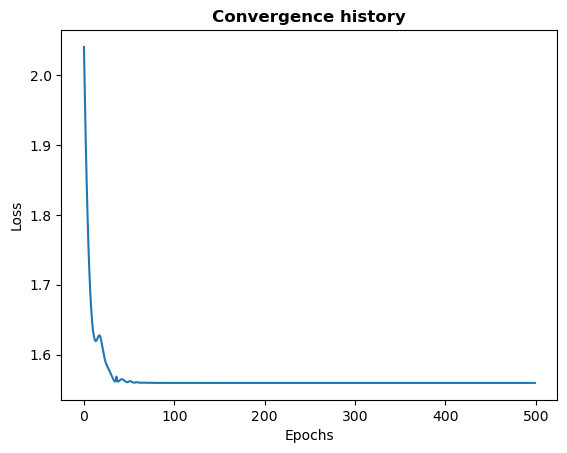

In [20]:
plt.plot(loss_history_ps)
plt.title("Convergence history", fontweight='demibold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()